In [1]:
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
from torch.utils.data import Dataset,DataLoader
from sklearn import manifold,metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from matplotlib import pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
#import ctypes
#ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

In [3]:
import kaldi_io

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [67]:
#Load the data
keys = []
matrices = []
mat_lengths = []


for key,matrix in kaldi_io.read_mat_scp('Data/raw_mfcc_AMI_Segments.9.scp'):
#for key,matrix in kaldi_io.read_mat_ark('Data/word_mfcc_features.ark'):
    keys.append(key.split('_')[1])
    matrices.append(matrix)
    mat_lengths.append(matrix.shape[0])
print(len(keys))

10598


In [68]:
# Function to truncate and limit dimensionality
def truncate_shapes(matrices,mat_lengths,max_length = 100,num_mfcc_features = 40):
    
    for i, seq in enumerate(matrices):
        matrices[i] = matrices[i][:max_length, :num_mfcc_features]
        mat_lengths[i] = min(mat_lengths[i], max_length)
    
    return matrices,mat_lengths 

In [69]:
#Function for padding
def pad_sequences(x, n_padded, center_padded=True):
    """Return the padded sequences and their original lengths."""
    padded_x = np.zeros((len(x), n_padded, x[0].shape[1]))
    lengths = []
    for i_data, cur_x in enumerate(x):
        length = cur_x.shape[0]
        if center_padded:
            padding = int(np.round((n_padded - length) / 2.))
            if length <= n_padded:
                padded_x[i_data, padding:padding + length, :] = cur_x
            else:
                # Cut out snippet from sequence exceeding n_padded
                padded_x[i_data, :, :] = cur_x[-padding:-padding + n_padded]
            lengths.append(min(length, n_padded))
        else:
            length = min(length, n_padded)
            padded_x[i_data, :length, :] = cur_x[:length, :]
            lengths.append(length)
    return padded_x, lengths

In [70]:
#Truncate the dimensions of the data
matrices,mat_lengths = truncate_shapes(matrices,mat_lengths,max_length=100,num_mfcc_features=40)

In [71]:
for mat in matrices:
    print(mat.shape)

(34, 40)
(58, 40)
(100, 40)
(21, 40)
(32, 40)
(37, 40)
(33, 40)
(34, 40)
(52, 40)
(32, 40)
(79, 40)
(19, 40)
(43, 40)
(97, 40)
(58, 40)
(23, 40)
(20, 40)
(46, 40)
(27, 40)
(51, 40)
(23, 40)
(29, 40)
(56, 40)
(69, 40)
(33, 40)
(53, 40)
(20, 40)
(43, 40)
(25, 40)
(44, 40)
(35, 40)
(38, 40)
(59, 40)
(48, 40)
(23, 40)
(63, 40)
(21, 40)
(32, 40)
(50, 40)
(37, 40)
(24, 40)
(44, 40)
(29, 40)
(19, 40)
(74, 40)
(100, 40)
(20, 40)
(18, 40)
(35, 40)
(20, 40)
(23, 40)
(34, 40)
(100, 40)
(96, 40)
(26, 40)
(100, 40)
(100, 40)
(54, 40)
(31, 40)
(27, 40)
(100, 40)
(57, 40)
(38, 40)
(29, 40)
(20, 40)
(95, 40)
(23, 40)
(31, 40)
(29, 40)
(31, 40)
(22, 40)
(26, 40)
(35, 40)
(21, 40)
(70, 40)
(20, 40)
(29, 40)
(29, 40)
(32, 40)
(25, 40)
(56, 40)
(37, 40)
(100, 40)
(55, 40)
(44, 40)
(29, 40)
(51, 40)
(20, 40)
(44, 40)
(100, 40)
(21, 40)
(26, 40)
(36, 40)
(51, 40)
(20, 40)
(26, 40)
(22, 40)
(28, 40)
(22, 40)
(32, 40)
(32, 40)
(46, 40)
(20, 40)
(30, 40)
(34, 40)
(27, 40)
(50, 40)
(53, 40)
(52, 40)
(38, 40)
(9

(19, 40)
(21, 40)
(30, 40)
(42, 40)
(59, 40)
(24, 40)
(36, 40)
(40, 40)
(70, 40)
(54, 40)
(25, 40)
(22, 40)
(37, 40)
(21, 40)
(100, 40)
(93, 40)
(100, 40)
(71, 40)
(26, 40)
(23, 40)
(28, 40)
(25, 40)
(38, 40)
(27, 40)
(25, 40)
(36, 40)
(32, 40)
(70, 40)
(26, 40)
(34, 40)
(43, 40)
(19, 40)
(24, 40)
(62, 40)
(22, 40)
(82, 40)
(31, 40)
(85, 40)
(22, 40)
(19, 40)
(33, 40)
(31, 40)
(31, 40)
(47, 40)
(47, 40)
(30, 40)
(41, 40)
(19, 40)
(23, 40)
(34, 40)
(22, 40)
(29, 40)
(34, 40)
(40, 40)
(35, 40)
(24, 40)
(20, 40)
(82, 40)
(20, 40)
(30, 40)
(100, 40)
(21, 40)
(20, 40)
(88, 40)
(33, 40)
(35, 40)
(34, 40)
(35, 40)
(55, 40)
(70, 40)
(33, 40)
(19, 40)
(31, 40)
(31, 40)
(20, 40)
(24, 40)
(30, 40)
(30, 40)
(20, 40)
(19, 40)
(22, 40)
(29, 40)
(22, 40)
(80, 40)
(42, 40)
(40, 40)
(53, 40)
(45, 40)
(26, 40)
(100, 40)
(23, 40)
(42, 40)
(54, 40)
(64, 40)
(40, 40)
(21, 40)
(40, 40)
(49, 40)
(28, 40)
(100, 40)
(74, 40)
(63, 40)
(23, 40)
(40, 40)
(21, 40)
(73, 40)
(28, 40)
(100, 40)
(19, 40)
(27, 40)
(58,

(23, 40)
(34, 40)
(36, 40)
(43, 40)
(27, 40)
(26, 40)
(53, 40)
(37, 40)
(30, 40)
(57, 40)
(82, 40)
(39, 40)
(56, 40)
(75, 40)
(100, 40)
(37, 40)
(23, 40)
(43, 40)
(25, 40)
(34, 40)
(63, 40)
(31, 40)
(45, 40)
(29, 40)
(28, 40)
(27, 40)
(26, 40)
(91, 40)
(25, 40)
(22, 40)
(33, 40)
(98, 40)
(26, 40)
(24, 40)
(32, 40)
(100, 40)
(100, 40)
(53, 40)
(46, 40)
(47, 40)
(22, 40)
(27, 40)
(100, 40)
(86, 40)
(28, 40)
(27, 40)
(24, 40)
(100, 40)
(33, 40)
(33, 40)
(46, 40)
(26, 40)
(31, 40)
(30, 40)
(69, 40)
(46, 40)
(20, 40)
(36, 40)
(55, 40)
(35, 40)
(38, 40)
(49, 40)
(32, 40)
(74, 40)
(53, 40)
(57, 40)
(59, 40)
(90, 40)
(79, 40)
(38, 40)
(34, 40)
(72, 40)
(23, 40)
(19, 40)
(27, 40)
(34, 40)
(36, 40)
(45, 40)
(23, 40)
(45, 40)
(46, 40)
(24, 40)
(35, 40)
(19, 40)
(39, 40)
(19, 40)
(84, 40)
(35, 40)
(30, 40)
(56, 40)
(39, 40)
(24, 40)
(29, 40)
(19, 40)
(19, 40)
(26, 40)
(31, 40)
(54, 40)
(27, 40)
(50, 40)
(27, 40)
(43, 40)
(51, 40)
(19, 40)
(54, 40)
(19, 40)
(25, 40)
(70, 40)
(31, 40)
(40, 40)
(40, 

(25, 40)
(100, 40)
(77, 40)
(44, 40)
(19, 40)
(39, 40)
(28, 40)
(39, 40)
(100, 40)
(22, 40)
(55, 40)
(19, 40)
(100, 40)
(84, 40)
(51, 40)
(46, 40)
(100, 40)
(26, 40)
(49, 40)
(93, 40)
(25, 40)
(39, 40)
(25, 40)
(19, 40)
(100, 40)
(31, 40)
(31, 40)
(24, 40)
(29, 40)
(29, 40)
(22, 40)
(34, 40)
(41, 40)
(39, 40)
(72, 40)
(30, 40)
(44, 40)
(31, 40)
(25, 40)
(53, 40)
(23, 40)
(61, 40)
(19, 40)
(32, 40)
(22, 40)
(29, 40)
(24, 40)
(35, 40)
(33, 40)
(27, 40)
(27, 40)
(48, 40)
(42, 40)
(100, 40)
(73, 40)
(46, 40)
(21, 40)
(56, 40)
(68, 40)
(31, 40)
(49, 40)
(37, 40)
(19, 40)
(19, 40)
(55, 40)
(25, 40)
(100, 40)
(61, 40)
(35, 40)
(100, 40)
(24, 40)
(25, 40)
(48, 40)
(31, 40)
(43, 40)
(30, 40)
(81, 40)
(100, 40)
(30, 40)
(27, 40)
(50, 40)
(19, 40)
(36, 40)
(48, 40)
(35, 40)
(23, 40)
(100, 40)
(35, 40)
(30, 40)
(100, 40)
(39, 40)
(22, 40)
(22, 40)
(37, 40)
(22, 40)
(100, 40)
(45, 40)
(43, 40)
(58, 40)
(26, 40)
(37, 40)
(100, 40)
(27, 40)
(100, 40)
(42, 40)
(31, 40)
(39, 40)
(47, 40)
(37, 40)
(59, 

(34, 40)
(20, 40)
(20, 40)
(55, 40)
(34, 40)
(94, 40)
(24, 40)
(100, 40)
(19, 40)
(19, 40)
(45, 40)
(100, 40)
(24, 40)
(32, 40)
(85, 40)
(61, 40)
(21, 40)
(21, 40)
(22, 40)
(23, 40)
(64, 40)
(25, 40)
(36, 40)
(28, 40)
(50, 40)
(29, 40)
(42, 40)
(39, 40)
(31, 40)
(100, 40)
(34, 40)
(66, 40)
(53, 40)
(27, 40)
(25, 40)
(26, 40)
(32, 40)
(28, 40)
(28, 40)
(19, 40)
(29, 40)
(36, 40)
(39, 40)
(36, 40)
(23, 40)
(100, 40)
(53, 40)
(20, 40)
(26, 40)
(20, 40)
(25, 40)
(100, 40)
(22, 40)
(19, 40)
(32, 40)
(33, 40)
(69, 40)
(29, 40)
(59, 40)
(25, 40)
(65, 40)
(75, 40)
(21, 40)
(25, 40)
(53, 40)
(27, 40)
(28, 40)
(51, 40)
(79, 40)
(49, 40)
(26, 40)
(31, 40)
(43, 40)
(100, 40)
(30, 40)
(37, 40)
(19, 40)
(40, 40)
(54, 40)
(83, 40)
(42, 40)
(26, 40)
(98, 40)
(99, 40)
(33, 40)
(22, 40)
(100, 40)
(25, 40)
(24, 40)
(25, 40)
(24, 40)
(24, 40)
(33, 40)
(33, 40)
(28, 40)
(37, 40)
(28, 40)
(28, 40)
(87, 40)
(40, 40)
(21, 40)
(29, 40)
(26, 40)
(21, 40)
(34, 40)
(27, 40)
(19, 40)
(20, 40)
(62, 40)
(70, 40)
(58

(28, 40)
(48, 40)
(33, 40)
(51, 40)
(62, 40)
(51, 40)
(70, 40)
(57, 40)
(100, 40)
(54, 40)
(38, 40)
(81, 40)
(29, 40)
(100, 40)
(24, 40)
(25, 40)
(35, 40)
(72, 40)
(56, 40)
(35, 40)
(64, 40)
(99, 40)
(27, 40)
(89, 40)
(95, 40)
(100, 40)
(30, 40)
(43, 40)
(35, 40)
(29, 40)
(47, 40)
(22, 40)
(33, 40)
(36, 40)
(33, 40)
(57, 40)
(92, 40)
(24, 40)
(19, 40)
(23, 40)
(19, 40)
(33, 40)
(19, 40)
(22, 40)
(87, 40)
(100, 40)
(28, 40)
(23, 40)
(97, 40)
(42, 40)
(30, 40)
(64, 40)
(100, 40)
(31, 40)
(44, 40)
(32, 40)
(100, 40)
(25, 40)
(24, 40)
(26, 40)
(43, 40)
(29, 40)
(63, 40)
(35, 40)
(31, 40)
(19, 40)
(87, 40)
(85, 40)
(43, 40)
(23, 40)
(45, 40)
(22, 40)
(63, 40)
(21, 40)
(29, 40)
(57, 40)
(100, 40)
(33, 40)
(21, 40)
(42, 40)
(45, 40)
(36, 40)
(58, 40)
(42, 40)
(32, 40)
(34, 40)
(31, 40)
(32, 40)
(99, 40)
(81, 40)
(40, 40)
(29, 40)
(100, 40)
(40, 40)
(23, 40)
(29, 40)
(44, 40)
(20, 40)
(84, 40)
(35, 40)
(52, 40)
(30, 40)
(29, 40)
(84, 40)
(26, 40)
(23, 40)
(28, 40)
(23, 40)
(77, 40)
(29, 40)
(1

(37, 40)


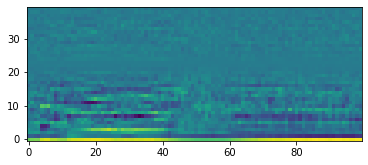

In [72]:
#See how a random matrix looks
plt.imshow(matrices[689].T, origin="bottom");

In [73]:
#Pad the matrices
matrices,mat_lengths = pad_sequences(matrices,n_padded = 100,center_padded = True)
matrices = np.transpose(matrices,(0,2,1))

In [74]:
matrices.shape

(10598, 40, 100)

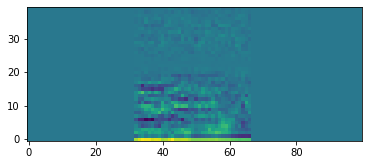

In [75]:
#See how a random matrix looks
plt.imshow(matrices[200], origin="bottom");

In [76]:

c = Counter(keys)
#print(c)
num_words = len(c.keys())
word_to_num = {}
num_to_word = {}

index = 0
for key in c.keys():
    word_to_num[key] = index
    num_to_word[index] = key
    index+=1

label_list = []
for key in keys:
    label_list.append(word_to_num[key])

print(len(c.keys()))

2804


In [77]:
print(c)

Counter({'Yeah': 63, 'just': 57, 'So': 56, 'um': 54, 'the': 53, 'that': 52, 'uh': 52, 'it': 52, 'to': 50, 'something': 49, 'Okay': 49, 'and': 47, 'like': 45, 'yeah': 44, 'have': 43, 'so': 41, 'I': 41, 'some': 40, 'we': 39, 'this': 39, 'for': 38, 'know': 38, 'think': 36, 'well': 36, 'one': 36, 'right': 36, 'if': 35, "it's": 35, 'is': 35, 'you': 34, 'then': 33, 'time': 33, 'what': 33, 'Uh': 33, 'of': 33, 'Well': 32, "don't": 32, 'okay': 32, 'about': 32, "that's": 31, 'Mm-hmm': 31, 'Um': 31, 'also': 31, 'And': 30, 'can': 30, 'which': 29, 'be': 29, 'because': 29, 'do': 29, 'different': 29, 'but': 28, 'on': 28, 'things': 27, 'probably': 27, 'or': 27, 'thing': 26, 'in': 26, 'Right': 26, 'maybe': 26, 'use': 25, 'No': 25, 'not': 25, 'a': 25, 'control': 25, 'more': 25, 'say': 24, 'should': 24, 'with': 24, 'But': 24, 'Oh': 24, 'mean': 24, 'could': 23, 'remote': 23, 'make': 23, 'very': 22, 'Mm': 22, 'T': 22, 'here': 22, 'from': 22, 'want': 21, 'all': 21, 'button': 21, 'buttons': 21, 'design': 21,

In [79]:
print(len(c.keys()))

2804


In [14]:
print(c)

Counter({'THE': 145, 'TO': 87, 'IN': 61, 'OF': 53, 'AND': 48, 'POINT': 43, 'A': 42, 'THREE': 41, 'PERCENT': 37, 'ONE': 36, 'THAT': 34, 'COMPANY': 33, 'HUNDRED': 33, 'ON': 33, 'FIVE': 28, 'SIX': 27, 'TWO': 26, 'FOR': 25, 'AT': 25, 'DOLLARS': 25, 'SAID': 24, 'WAS': 24, 'MILLION': 24, 'SEVEN': 22, 'IS': 21, 'AS': 20, 'ARE': 20, 'NEW': 19, 'IT': 19, 'FROM': 18, 'WITH': 18, 'ABOUT': 18, 'TWENTY': 17, 'BE': 17, 'ITS': 16, 'FOUR': 16, 'HE': 16, 'NINETEEN': 16, 'THOUSAND': 16, 'BUT': 16, 'NINE': 15, 'STOCK': 15, 'SHARES': 14, 'HAS': 13, 'WERE': 13, 'BY': 13, 'HAVE': 13, 'EIGHT': 13, 'FORTY': 13, 'FIFTY': 13, 'ANALYSTS': 12, 'YEAR': 11, 'WOULD': 11, 'WILL': 11, 'EIGHTY': 11, 'MAY': 11, 'THIRTY': 10, 'THEY': 10, 'SHARE': 10, 'NINETY': 10, 'ROSE': 9, 'LAST': 9, 'SEVENTY': 9, 'WE': 9, 'AFTER': 9, 'EXCHANGE': 9, 'YORK': 9, 'AN': 8, 'THEIR': 8, 'COMPANIES': 8, 'WHICH': 8, 'UP': 8, 'THIS': 8, 'QUARTER': 8, 'INDEX': 8, 'SOME': 8, 'HAD': 8, 'OTHER': 7, 'BIG': 7, 'BUSINESS': 7, 'AUCTION': 7, 'OR': 7, 'L

In [15]:
print([(word,c[word]) for word in sorted(c.keys())])

[('A', 42), ('ABOUT', 18), ('ABOVE', 3), ('ACCEPTED', 1), ('ACCEPTS', 1), ('ACCORDING', 3), ('ACQUIRE', 2), ('ACROSS', 1), ('ACT', 2), ('ACTION', 1), ('ACTUAL', 2), ('ADDITIONAL', 1), ('ADDS', 1), ('ADMINISTRATION', 2), ('ADVANCING', 2), ('ADVISER', 3), ('AFFECT', 1), ('AFFECTED', 2), ('AFFILIATE', 2), ('AFTER', 9), ('AFTERNOON', 1), ('AGAIN', 2), ('AGENCY', 1), ('AGGREGATE', 1), ('AGREE', 1), ('AGREEMENT', 2), ('AGRICULTURAL', 1), ('AIMED', 2), ('AIMING', 1), ('AIRCRAFT', 2), ('AIRING', 3), ('AIRLINE', 1), ('AIRLINES', 2), ('ALL', 6), ('ALMOST', 1), ('ALREADY', 3), ('ALSO', 7), ('ALTHOUGH', 2), ('AMAZINGLY', 1), ('AMERICA', 1), ('AMERICAN', 6), ('AMONG', 4), ('AMOUNT', 1), ('AN', 8), ('ANALYST', 1), ('ANALYSTS', 12), ('AND', 48), ('ANNUALLY', 1), ('ANOTHER', 1), ('ANTICIPATED', 2), ('ANY', 2), ('APPEAL', 1), ('ARE', 20), ('ARGUMENTS', 1), ('ARIZONA', 1), ('AROUND', 2), ('ARRANGED', 1), ('ARRANGEMENT', 1), ('AS', 20), ('ASHLAND', 1), ('ASKING', 1), ('ASPECTS', 1), ('ASSETS', 3), ('ASSU

In [16]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [17]:
inputs = np.stack(matrices)
inputs = np.expand_dims(inputs,1)
labels = np.array(label_list)
print(inputs.shape)
print(labels.shape)


(3449, 1, 40, 100)
(3449,)


In [18]:
x_trainval,x_test,y_trainval,y_test = train_test_split(inputs, labels, test_size=0.2, random_state=42)

In [19]:
x_train,x_val,y_train,y_val = train_test_split(x_trainval,y_trainval,test_size =0.25, random_state = 42)

In [20]:
x_train,y_train = torch.tensor(x_train,dtype= torch.float),torch.tensor(y_train, dtype= torch.float)
x_val,y_val = torch.tensor(x_val, dtype= torch.float),torch.tensor(y_val, dtype= torch.float)
x_test,y_test = torch.tensor(x_test, dtype= torch.float),torch.tensor(y_test, dtype= torch.float)

In [21]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

torch.Size([2069, 1, 40, 100]) torch.Size([2069])
torch.Size([690, 1, 40, 100]) torch.Size([690])
torch.Size([690, 1, 40, 100]) torch.Size([690])


In [22]:
x_train[20].squeeze()[0]

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000, 101.9694,  98.7186,  88.2952,  80.9519,  80.3870,
         79.6338,  85.4708,  88.2952,  93.0024,  92.8141,  91.3078,  97.0933,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.00

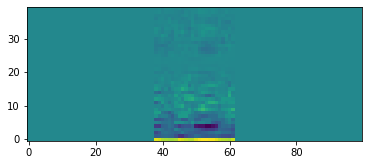

In [23]:
plt.imshow(x_train[10].squeeze(), origin = "bottom")

In [24]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, pin_memory = True)

val_ds = TensorDataset(x_val, y_val)
val_dl = DataLoader(val_ds, batch_size=bs, pin_memory = True)

In [25]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1,96,(40,10))
        self.pool = nn.MaxPool2d(1, 3)
        self.conv2 = nn.Conv2d(96, 96, (1,8))
        self.fc1 = nn.Linear(768, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, len(c.keys()))
        self.sm = nn.Softmax(dim = 1)
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 768)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = F.log_softmax(x,dim=1)
        #print(x.shape)
        #print("Done")
        return x
    
    def give_embeddings(self,x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 768)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        return x.detach().numpy()




In [26]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.conv1 = nn.Conv2d(1,96,(40,10))
        self.pool = nn.MaxPool2d(1, 3)
        self.conv2 = nn.Conv2d(96, 96, (1,8))
        self.fc1 = nn.Linear(768, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, len(c.keys()))
        self.sm = nn.Softmax(dim = 1)
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 768)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = F.log_softmax(x,dim=1)
        #print(x.shape)
        #print("Done")
        return x
    
    def give_embeddings(self,x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 768)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        return x.cpu().detach().numpy() if dev.type == 'cuda' else x.detach().numpy()




In [27]:
#net = SimpleNet()
net = SiameseNet()
net = net.float()
net.to(dev)

SiameseNet(
  (conv1): Conv2d(1, 96, kernel_size=(40, 10), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 96, kernel_size=(1, 8), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=981, bias=True)
  (sm): Softmax(dim=1)
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [29]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [30]:
def train_model(net,num_epochs,train_dl,val_dl,save_path = "./Models/"):
    
    best_val_loss = np.Inf
    best_val_acc = np.NINF
    for epoch in range(0,num_epochs):  # loop over the dataset multiple times
        print('epoch %d '%(epoch))

        train_loss = 0
        train_acc = 0
        net.train()
        for xb,yb in train_dl:
            
            #Move to GPU
            xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
            
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = torch.tensor(inputs),torch.tensor(labels)
            #labels = labels.long()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(xb)
            loss = criterion(outputs, yb.long())
            train_loss += loss.item()
            train_acc += accuracy(outputs,yb)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss = loss.item()
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for xb,yb in val_dl:
                
                #Move to GPU
                xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
                
                val_loss += criterion(net(xb),yb.long())
                val_acc += accuracy(net(xb), yb.long())
            #val_loss = sum(criterion(net(xb), yb.long()) for xb, yb in val_dl)
            #val_acc = sum(accuracy(net(xb), yb.long()) for xb, yb in val_dl)
            if val_acc.cpu().detach().numpy() > best_val_acc:
                best_val_acc = val_acc.cpu().detach().numpy()
                path = save_path + "l2_best_model.pth"
                print("Best val acc. Saving model...")
                torch.save(net.state_dict(), path)


        print("train loss: %.3f train acc: %.3f"%(train_loss/len(train_dl),train_acc/len(train_dl)))
        print("val loss: %.3f val acc: %.3f"%(val_loss/len(val_dl),val_acc/len(val_dl)))
        if epoch%5 == 0:
            path = save_path + "simple_awe_bs64_epoch_%d.pth"%(epoch)
            torch.save(net.state_dict(), path)


    print('Finished Training')

In [31]:
def evaluate_model(net,features,labels, diagonal_pairs = True):
    
    #If device is GPU move features to GPU
    if dev.type == 'cuda':
        features = features.to(dev, non_blocking = True)
    
    #Get the embeddings
    embeddings = net.give_embeddings(features)
    #Calculate pairwise cosine distance
    distances = pairwise_distances(embeddings, metric='cosine')
    #Calculate pairwise cosine similarity
    similarity = pairwise_kernels(embeddings, metric = 'cosine')
    
    
    
    #Create labels of whether the words are same or not
    if torch.is_tensor(labels):
        labels = labels.detach().numpy()
        
    eval_labels = (labels[:,None]==labels).astype(float)
    
    
    if not diagonal_pairs:
        #Remove the diagonal elements (word pairs with themselves)
        #mask = ~np.eye(similarity.shape[0],dtype = bool)
        mask = np.array(np.tril(np.ones((similarity.shape[0],similarity.shape[0])),-1),dtype = bool)
        similarity = similarity[mask]
        distances = distances[mask]
        eval_labels = eval_labels[mask]
        
    #flatten the pairwise arrays
    distances = np.ravel(distances)
    similarity = np.ravel(similarity)
    #Flatten the labels
    eval_labels = np.ravel(eval_labels)
    
    num_positive = sum(eval_labels==1)
    num_negative = eval_labels.shape[0]-num_positive
    print('The number of positive examples %d and negative examples %d'%(num_positive,num_negative))
    #Calculate the Average Precision
    #avg_p = average_precision_score(eval_labels,similarity)
    avg_p = average_precision_score(eval_labels,2-distances)
    #avg_p = average_precision_score(eval_labels,2-distances)
    print('Average Precision is %f'%(avg_p))

            
            

In [32]:
train = False

In [33]:
if train:
    train_model(net,100,train_dl,val_dl,save_path="./Models/")
else:
    print('Not training the model')

Not training the model


In [34]:
#Load the best model
best_model_path = "./Models/libre_best_model.pth"
net.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [35]:
print(dev.type == 'cuda')

True


In [36]:
if dev.type == 'cuda':
    y_pred = net(x_test.to(dev, non_blocking = True))
    test_acc = accuracy(y_pred,y_test.to(dev, non_blocking = True).long())
elif dev.type == 'cpu':
    y_pred = net(x_test)
    test_acc = accuracy(y_pred,y_test.long())
    
print("Test Accuracy of best model is %.3f"%(test_acc))

Test Accuracy of best model is 0.348


In [37]:
evaluate_model(net,x_test,y_test,diagonal_pairs = False)

The number of positive examples 1456 and negative examples 236249
Average Precision is 0.150812


In [38]:
#Whether to retrain the model on train+test data
retrain_on_traintest = False

In [39]:
if retrain_on_traintest:
    #Get the traintest data by mergin training and test data
    x_traintest = np.vstack((x_train.numpy().squeeze(),x_test.numpy().squeeze()))
    y_traintest = np.concatenate((y_train.numpy(),y_test.numpy()),axis=0)

    x_traintest = np.expand_dims(x_traintest,1)

    x_traintest = torch.tensor(x_traintest,dtype = torch.float)
    y_traintest = torch.tensor(y_traintest,dtype = torch.float)

    print(x_traintest.shape)
    print(y_traintest.shape)
    
    #Create traintest Dataset and Dataloader
    bs = 64
    traintest_ds = TensorDataset(x_traintest, y_traintest)
    traintest_dl = DataLoader(traintest_ds, batch_size=bs, pin_memory = True)
    
    #Train on training and test data, use validation to select the best model
    train_model(net,100,traintest_dl,val_dl,save_path = "./Models/traintest/")
else:
    #Load the best model
    best_model_path = "./Models/traintest/libre_best_model.pth"
    net.load_state_dict(torch.load(best_model_path))
    print('Not retraining')

Not retraining


In [40]:
evaluate_model(net,x_test,y_test,diagonal_pairs = False)

The number of positive examples 1456 and negative examples 236249
Average Precision is 0.169642


In [41]:
train_words = set([num_to_word[y_train[i].item()] for i in range(y_train.shape[0])])
val_words = set([num_to_word[y_val[i].item()] for i in range(y_val.shape[0])])
test_words = set([num_to_word[y_test[i].item()] for i in range(y_test.shape[0])])

In [42]:
def give_tsne(net,inputs):
    
    if dev.type == 'cuda':
        inputs = inputs.to(dev, non_blocking = True)
    embeddings = net.give_embeddings(inputs)
    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    tsne_vectors = tsne.fit_transform(embeddings)
    
    return tsne_vectors


In [43]:
def add_membership(word):
    train_tag = "Tr" if word in train_words else ""
    val_tag = "|Val" if word in val_words else ""
    test_tag = "|Ts" if word in test_words else ""
    return word+" (%s%s%s)"%(train_tag,val_tag,test_tag)

In [44]:
def visualize_words(word_list,tsne_vectors,labels,rigid_limits = False):
    #Get ids of words from labels
    num_list = [word_to_num[word] for word in word_list]
    ids = np.where(np.isin(labels,np.array(num_list)))
    
    df_subset = {}
    df_subset['tsne-2d-one'] = tsne_vectors[ids][:,0]
    df_subset['tsne-2d-two'] = tsne_vectors[ids][:,1]
    df_subset['Word'] = [num_to_word[labels[ids][i].item()] for i in range(ids[0].shape[0])]
    
    #Convert to dataframe
    df_subset = pd.DataFrame(df_subset)
    #Add membership tags
    df_subset['Word'] = df_subset['Word'].apply(add_membership)
    
    #print(df_subset['tsne-2d-one'].shape)
    #print(df_subset['tsne-2d-two'].shape)
    #print(len(df_subset['y']))
    
    #print(ids)
    #print(df_subset['y'])
    
    g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Word",
    data=df_subset,
    legend="full",
    alpha=0.5)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    if rigid_limits:
        x_coordinate = tsne_vectors[:,0]
        y_coordinate = tsne_vectors[:,1]
        epsilon = 5
        plt.xlim(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
        plt.ylim(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)
    

In [45]:
tsne_vectors = give_tsne(net,torch.tensor(inputs,dtype=torch.float))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3449 samples in 0.923s...
[t-SNE] Computed neighbors for 3449 samples in 17.629s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3449
[t-SNE] Computed conditional probabilities for sample 2000 / 3449
[t-SNE] Computed conditional probabilities for sample 3000 / 3449
[t-SNE] Computed conditional probabilities for sample 3449 / 3449
[t-SNE] Mean sigma: 31.335456
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.774117
[t-SNE] KL divergence after 500 iterations: 1.728038


In [46]:
x_coordinate = tsne_vectors[:,0]
y_coordinate = tsne_vectors[:,1]
epsilon = 5
print(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
print(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)

-53.61260223388672 48.65258026123047
-37.48564147949219 45.11390686035156


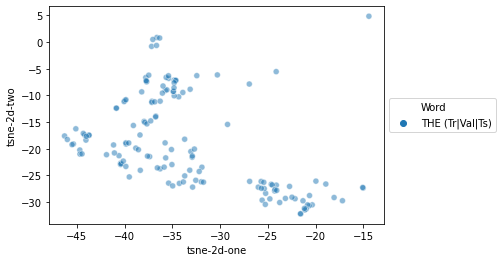

In [47]:
word_list = ["THE"]
visualize_words(word_list,tsne_vectors,labels)

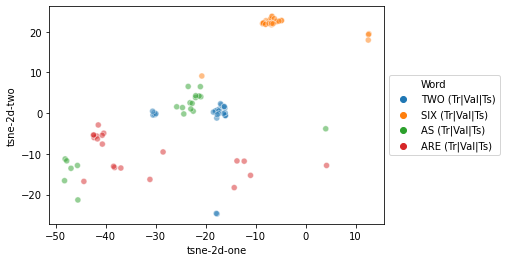

In [48]:
word_list = ["AS","ARE","TWO","SIX"]
visualize_words(word_list,tsne_vectors,labels)

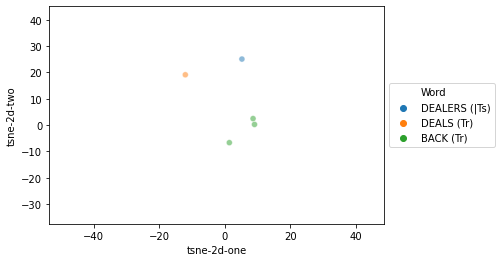

In [49]:
word_list = ["DEALERS","DEALS","BACK"]
visualize_words(word_list,tsne_vectors,labels,True)

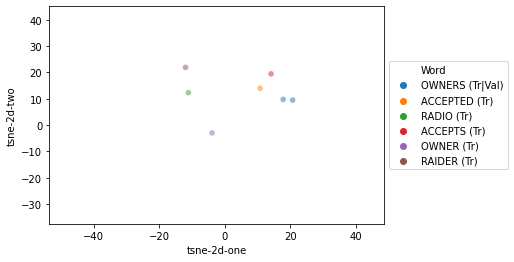

In [50]:
word_list = ["ACCEPTED","ACCEPTS","RADIO","RAIDER","OWNER","OWNERS"]
visualize_words(word_list,tsne_vectors,labels,True)

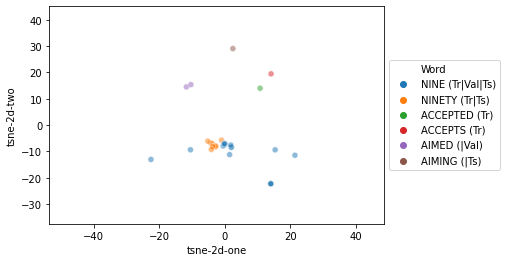

In [51]:
word_list = ["NINE","NINETY","ACCEPTED","ACCEPTS","AIMED","AIMING"]
visualize_words(word_list,tsne_vectors,labels,True)

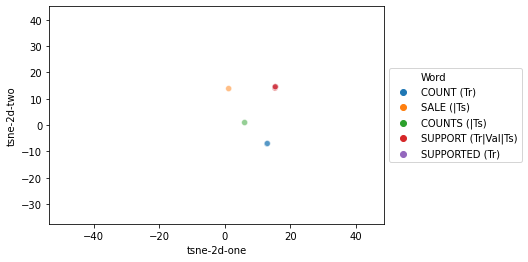

In [52]:
word_list = ["COUNT","COUNTS","SALE","SUPPORT","SUPPORTED"]
visualize_words(word_list,tsne_vectors,labels,True)

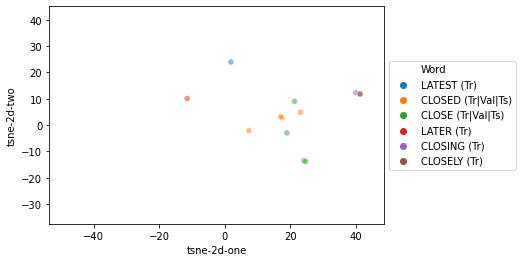

In [53]:
word_list = ["LATER","LATEST","CLOSE","CLOSING","CLOSED","CLOSELY"]
visualize_words(word_list,tsne_vectors,labels,True)

In [54]:
def nearest_neighbors(net,inputs,labels,n_neighbors = 3):
    
    if dev.type == 'cuda':
        inputs = inputs.to(dev, non_blocking = True)
    embeddings = net.give_embeddings(inputs)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute',metric = 'cosine').fit(embeddings)
    distances,indices = nbrs.kneighbors(embeddings)
    
    return distances,indices
    

In [55]:
def nearest_neighbors_for_word(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [56]:
distances,indices = nearest_neighbors(net,torch.tensor(inputs,dtype=torch.float),labels,n_neighbors=5)

In [57]:
word = "SUPPORT"
nearest_neighbors_for_word(word,indices,labels)

['SUPPORT', 'REPORTED', 'DECLINED', 'SUPPORT', 'SUPPORTED']
['SUPPORT', 'SUPPORT', 'DOUBLED', 'SUPPORTED', 'UNSOLD']
['SUPPORT', 'SUPPORT', 'SUPPORTED', 'RESTORE', 'SUPPORT']


In [58]:
word = "LATER"
nearest_neighbors_for_word(word,indices,labels)

['LATER', 'RADIO', 'NEEDED', 'UNDER', 'NEW']


In [59]:
word = "CLOSING"
nearest_neighbors_for_word(word,indices,labels)

['CLOSING', 'ELECTION', 'ELECTION', 'CLOSELY', 'CLOSELY']


In [60]:
word = "ACCEPTED"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTED', 'EXPECTED', 'ACCEPTS', 'SPECIFICALLY', 'INCENTIVES']


In [61]:
word = "DEALS"
nearest_neighbors_for_word(word,indices,labels)

['DEALS', 'BIDS', 'YIELDS', 'JUST', 'YIELD']


In [62]:
word = "RANGE"
nearest_neighbors_for_word(word,indices,labels)

['RANGE', 'GAINS', 'EIGHTH', 'GAINS', 'AIMED']
['RANGE', 'MANY', 'RANGED', 'CANADIAN', 'UNION']
['RANGE', 'ARRANGED', 'BRADY', 'GAIN', "MONDAY'S"]


In [63]:
word = "DAY"
nearest_neighbors_for_word(word,indices,labels)

['DAY', 'BIG', 'NEW', 'EIGHTY', 'BE']
['DAY', 'MAY', 'AIMING', 'EIGHTH', 'NINETEEN']
['DAY', 'MAY', 'IN', 'END', 'BID']
['DAY', 'YOU', 'THEIR', 'EIGHT', 'MILLION']


In [64]:
word = "CARE"
nearest_neighbors_for_word(word,indices,labels)

['CARE', 'YEAR', 'DO', 'TERM', 'YEAR']
['CARE', 'CARE', 'TERM', 'TERM', 'SHOW']
['CARE', 'THERE', 'FOUR', 'CARE', 'SHARE']


In [65]:
def filter_infrequent_words(labels,threshold = 2):
    '''For a given list of labels, returns index of frequent words 
    (words having frequency greater than or equal to the threshold)
    '''
    if torch.is_tensor(labels):
        label_counter = Counter(labels.detach().numpy())
    else:
        label_counter = Counter(labels)
    print('Number of unique words in labels %d'%(len(word_counter)))
    
    #Remove infrequent words from the Counter
    for key,value in tuple(label_counter.items()):
        if not (value>=threshold):
            label_counter.pop(key)
    print('Number of unique words with frequency atleast %d is %d'%(threshold,len(word_counter)))
    
    #Get the labels for the frequent words
    frequent_word_labels = np.array(tuple(label_counter.keys()))
    frequent_word_indices = np.where(np.isin(labels,frequent_word_labels))
    
    return frequent_word_indices,frequent_word_labels

In [66]:
#frequent_word_indices,frequent_word_labels = filter_infrequent_words(y_train)